This notebook includes a first sketch of the ShorelineNet implementation in pytorch. 

In particular I want to achieve the following: 
* config loading
* network saving & loading
* try to wrap everything in classes
* where possible, use type annotations
* experiment with MC dropout & posterior estimation

15 Jan: loaded images

16 Jan: augmentation pipeline

17 Jan: Create network architecture & load pre-trained encoder

18 Jan: Set up loss function & training loop

In [99]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [100]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys

from tqdm.notebook import tqdm
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary

ENV = 'colab' # 'local'

if ENV == 'colab':
  from google.colab import drive
  drive.mount("/content/drive/") # TODO: mount only a subset of folders to make things load faster?

  # copy dataset to local env
  if 'data' not in os.listdir():
    !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
    !unzip -q 'mastr.zip' -d data
    !rm 'mastr.zip'

  mastr_path = '/content/data/'
  module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"
elif ENV == 'local':
  mastr_path = '../../project_offline/Dataset/MaSTr1325/'
  module_dir = '..'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cd '/content/drive/My Drive/ShorelineNet_pytorch'

In [101]:
# import local modules
from utils.transforms import ToTensor, HFlip, Rotation, HueSatCon, Crop, Resize
from helper.visualization import ImageDisplayer, show_features
from utils.mastr_dataset import MastrDataset
from model.unet_mobilenetv2 import Unet_MobileNetV2, Unet_MobileNetV2_Decoder, Encoder_feature_extractor

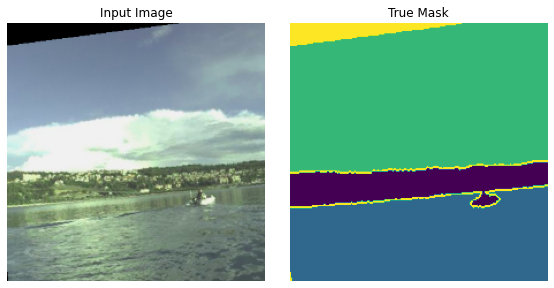

In [102]:
# define transformations 
custom_transforms = transforms.Compose([
    ToTensor(),
    HFlip(prob=0.5),
    Rotation(15, prob=1),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Crop(0.8),
    Resize((224, 224)),
])

dataset = MastrDataset(os.path.join(mastr_path, 'images'),
                       os.path.join(mastr_path, 'masks'),
                       custom_transforms)

train_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

sample = next(iter(train_dataloader))

imgs, labels = sample['image'], sample['mask']
img_displayer = ImageDisplayer(imgs, labels)
img_displayer.show_sample(idx=0)


### Encoder definition

In [112]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

# print(mobileNet)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [113]:
feature_extractor = Encoder_feature_extractor(mobileNet)

# dummy forward pass
dummy_input = torch.rand((2, 3, 224, 224))

out = mobileNet(dummy_input)

print(out.shape)

for (key, value) in feature_extractor.features.items():
    print(f'{key}: {value.shape}')

torch.Size([2, 320])
skip_1: torch.Size([2, 96, 112, 112])
skip_2: torch.Size([2, 144, 56, 56])
skip_3: torch.Size([2, 192, 28, 28])
skip_4: torch.Size([2, 576, 14, 14])
skip_5: torch.Size([2, 320, 7, 7])


### UNET definition

In [114]:
encoder = mobileNet
for param in encoder.parameters():
    param.requires_grad = False
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

unet.to(device)
print(device)

cuda:0


In [96]:
# sum([p.numel() for p in decoder.parameters()])
# print([p for p in unet.decoder.parameters() if p.requires_grad])

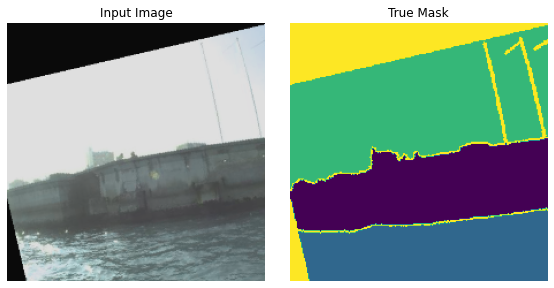

In [141]:
img_displayer.show_sample(12)

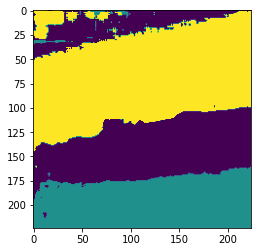

In [146]:
i = 12
unet.eval()

with torch.no_grad():
  plt.imshow(torch.argmax(unet(imgs[i:i+1].to(device))[0], dim=0).cpu().detach().numpy())

unet.train()
print('')

In [ ]:
# show_features(feature_extractor.features['skip_1'])

In [ ]:
# show_features(feature_extractor.features['skip_2'])

### Loss function definition 

In [49]:
# Testing loss functions

y_pred = torch.tensor([[1, 0, 0], [0.5, 0.5, 0.], [0.5, 0.5, 0], [1, 0, 0]], dtype=float)
y_pred_correct = torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]], dtype=float)

y_target = torch.tensor([0, 0, 0, 0], dtype=float)
# BCE_loss = nn.functional.cross_entropy(y_pred, y_target)
y_target_one_hot = nn.functional.one_hot(y_target.long(), num_classes=3).float()
BCE_loss = nn.functional.binary_cross_entropy_with_logits(
    y_pred_correct, y_target_one_hot)
focalLoss = torchvision.ops.sigmoid_focal_loss(y_pred, y_target_one_hot, reduction='sum')

print(BCE_loss)
print(focalLoss)

print(y_pred.shape)
print(y_target_one_hot.shape)
# print(torch.sigmoid(y_pred))


# def binary_cross_entropy(input, y): return -(pred.log()*y + (1-y)*(1-pred).log()).mean()


tensor(0.8999)
tensor(1.3910, dtype=torch.float64)
torch.Size([4, 3])
torch.Size([4, 3])


In [116]:
def Focal_loss(y_true, y_pred):
    mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))

    y_true *= mask 
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    mask = mask.unsqueeze(dim=1)
    y_pred *= mask
    # TODO: double that gradients will not flow through to masked pixels

    loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (loss * mask).sum() / mask.sum()
    # loss = loss.mean()

    return loss
  
y_pred = torch.zeros((2, 3, 224, 224))
y_target = torch.randint(0, 4, (2, 224, 224))


loss = Focal_loss(y_target, y_pred)
# loss.backward()
print(loss)



# def sigmoid(x): return (1 + (-x).exp()).reciprocal()

# y_pred = torch.tensor([[[1, 0, 0], [0.5, 0.5, 0.], [0.5, 0.5, 0], [1, 0, 0]]], dtype=float)
# y_target = torch.tensor([[0, 0, 0, 0]], dtype=float)


# def custom_focal_loss(y_true, y_pred):
#     # print(f'y_true: {y_true.shape}')
#     # print(f'y_pred: {y_pred.shape}')
#     y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)
#     y_pred = sigmoid(y_pred)

#     # print(y_true_one_hot.shape)
#     # print(y_pred.shape)

#     mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true)).unsqueeze(1)

#     return loss




tensor(0.3033)


In [117]:
unet.to(device)

print(device)


cuda:0


In [129]:
history = []
N_epochs = 60

opt = torch.optim.Adam(unet.parameters())

for epoch in range(N_epochs):
    train_loss = 0.0
    for item in tqdm(train_dataloader):
        X, y = item['image'], item['mask'].squeeze()

        # TODO: this isn't the most efficient way to load the data into GPU
        X, y = X.to(device), y.to(device)
        y_pred = unet(X)
        opt.zero_grad()
        loss = Focal_loss(y, y_pred)
        loss.backward()
        opt.step()
        # print(loss.item())
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    print("Epoch %d, train loss = %0.4f" % (epoch+1, train_loss))
    history.append(train_loss)


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1, train loss = 0.0047


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2, train loss = 0.0045


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3, train loss = 0.0044


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4, train loss = 0.0043


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5, train loss = 0.0043


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6, train loss = 0.0042


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7, train loss = 0.0042


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8, train loss = 0.0043


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9, train loss = 0.0042


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11, train loss = 0.0041


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 12, train loss = 0.0041


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 13, train loss = 0.0042


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 14, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 16, train loss = 0.0041


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 17, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 18, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 19, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 20, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 21, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 22, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 23, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 24, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 25, train loss = 0.0041


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 26, train loss = 0.0043


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 27, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 28, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 29, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 30, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 31, train loss = 0.0039


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 32, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 33, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 34, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 35, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 36, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 37, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 38, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 39, train loss = 0.0037


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 40, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 41, train loss = 0.0037


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 42, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 43, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 44, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 45, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 46, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 47, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 48, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 49, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 50, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 51, train loss = 0.0034


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 52, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 53, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 54, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 55, train loss = 0.0034


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 56, train loss = 0.0038


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 57, train loss = 0.0040


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 58, train loss = 0.0036


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 59, train loss = 0.0035


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 60, train loss = 0.0035
